In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *

%matplotlib notebook

In [2]:
sub = Subjects()
print(sub)

Number of Subjects: 8

0 -> ID: WT_74 RECs: 3
1 -> ID: KO_70 RECs: 3
2 -> ID: KO_72 RECs: 3
3 -> ID: WT_79 RECs: 3
4 -> ID: KO_69 RECs: 3
5 -> ID: WT_71 RECs: 3
6 -> ID: WT_81 RECs: 3
7 -> ID: KO_75 RECs: 3



In [3]:



def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')




## 24 Hours average

<IPython.core.display.Javascript object>


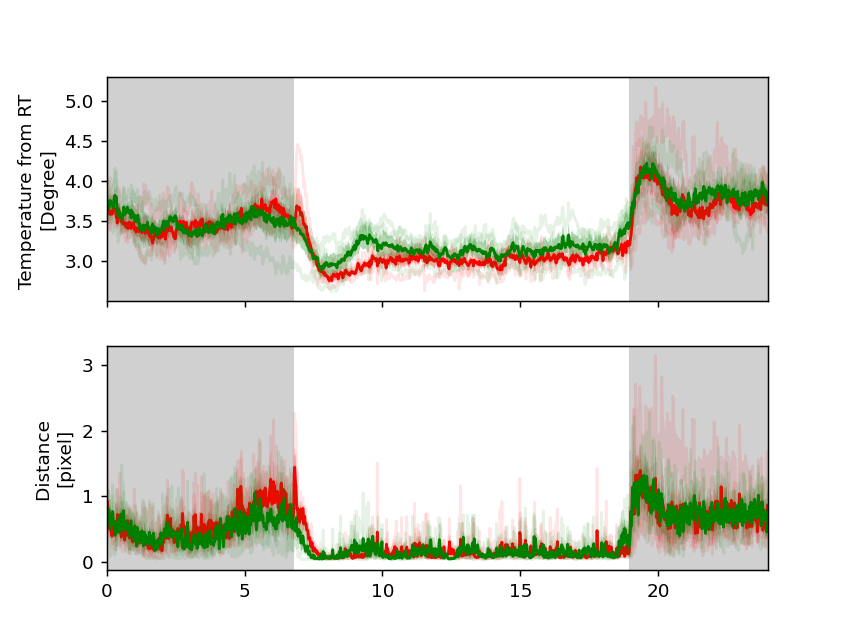

Text(0, 0.5, 'Distance \n[pixel]')

In [4]:


# motion 
motion = dict()
for info,rec in sub.iter_data_day():
    motion[(info['geno'], info['id'])] = rec['distance']
isDay = rec.isDay
motion = pd.DataFrame.from_dict(motion,)
motion.index = motion.index/60

# temperature 
temperature = dict()
for info,rec in sub.iter_data_day():
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
isDay = rec.isDay
temperature = pd.DataFrame.from_dict(temperature,)
temperature.index = temperature.index/60

fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg(temperature.xs('KO',level=0,axis=1), isDay,color='r',ax=ax[0])
plot_avg(temperature.xs('WT',level=0,axis=1), isDay,color='g',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')

plot_avg(motion.xs('KO',level=0,axis=1), isDay,color='r', ax=ax[1])
plot_avg(motion.xs('WT',level=0,axis=1), isDay,color='g', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')

<IPython.core.display.Javascript object>


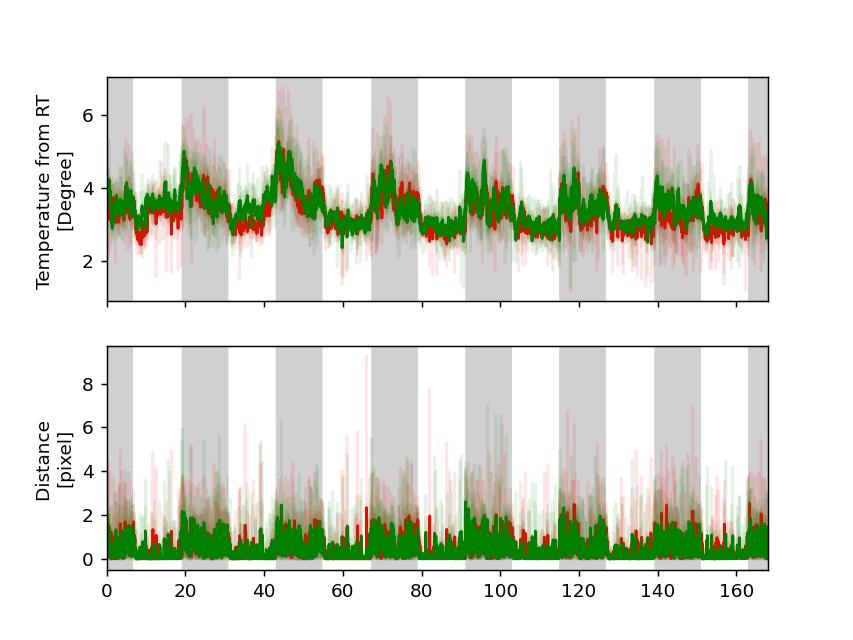

Text(0, 0.5, 'Distance \n[pixel]')

In [5]:


# motion 
motion_minutes = dict()
for info,rec in sub.iter_data_min():
    motion_minutes[(info['geno'], info['id'])] = rec['distance']
isDay = rec.isDay
motion_minutes = pd.DataFrame.from_dict(motion_minutes,)
motion_minutes.index = motion_minutes.index/60

# temperature 
temperature_minute = dict()
for info,rec in sub.iter_data_min():
    temperature_minute[(info['geno'], info['id'])] = rec['temp_rt_diff']
isDay = rec.isDay
temperature_minute = pd.DataFrame.from_dict(temperature_minute,)
temperature_minute.index = temperature_minute.index/60

fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg(temperature_minute.xs('KO',level=0,axis=1), isDay,color='r',ax=ax[0])
plot_avg(temperature_minute.xs('WT',level=0,axis=1), isDay,color='g',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')

plot_avg(motion_minutes.xs('KO',level=0,axis=1), isDay,color='r', ax=ax[1])
plot_avg(motion_minutes.xs('WT',level=0,axis=1), isDay,color='g', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')

# Spectral Density

<IPython.core.display.Javascript object>


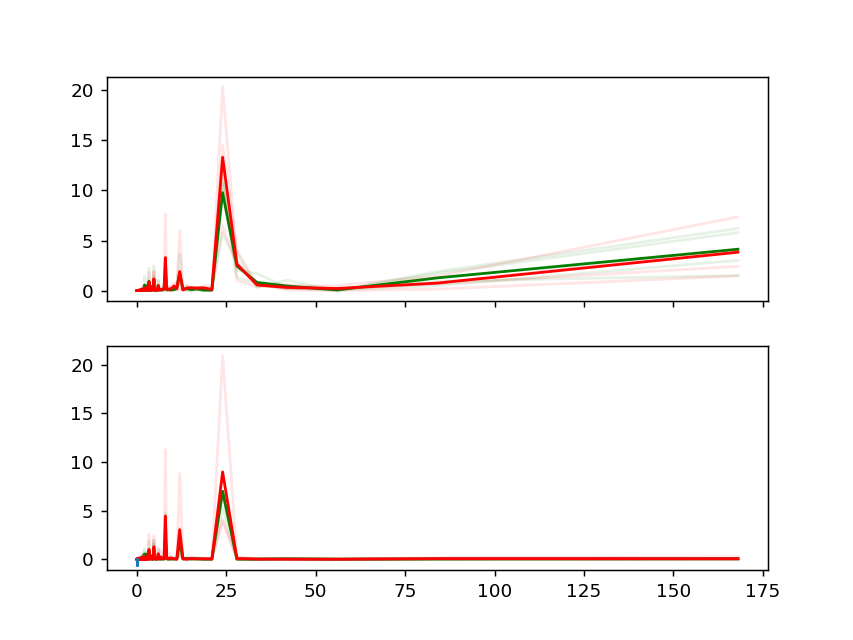

In [6]:
fig,ax = plt.subplots(2,1,sharex=True)

wt_temperature = temperature_minute.xs('WT',level=0,axis=1).fillna(0)
wt_temperature_psd = dict()
wt_temperature_params = list()
for c in wt_temperature.columns:
    cosinor = Cosinor(wt_temperature[c].values)
    wt_temperature_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'WT'
    wt_temperature_params.append( cosinor.compontents )
    ax[0].plot(cosinor.period ,cosinor.power_spectrum,color='g', alpha = .1)
wt_temperature_psd = pd.DataFrame.from_dict(wt_temperature_psd)
wt_temperature_psd.index = cosinor.period 
ax[0].plot(wt_temperature_psd.index , wt_temperature_psd.mean(axis=1), color='g', alpha = 1)

ko_temperature = temperature_minute.xs('KO',level=0,axis=1).fillna(0)
ko_temperature_psd = dict()
ko_temperature_params = list()
for c in ko_temperature.columns:
    cosinor = Cosinor(ko_temperature[c].values)
    ko_temperature_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'KO'
    ko_temperature_params.append( cosinor.compontents )
    ax[0].plot(cosinor.period , cosinor.power_spectrum, color='r', alpha = .1)
ko_temperature_psd = pd.DataFrame.from_dict(ko_temperature_psd)
ko_temperature_psd.index = cosinor.period 
ax[0].plot(ko_temperature_psd.index , ko_temperature_psd.mean(axis=1), color='r', alpha = 1)

temperature_params = pd.concat([pd.concat(wt_temperature_params), pd.concat(ko_temperature_params)])
temperature_params['acrophase_rad'] = temperature_params['acrophase'].apply(hour2radians)

wt_motion = motion_minutes.xs('WT',level=0,axis=1).fillna(0)
wt_motion_psd = dict()
for c in wt_motion.columns:
    cosinor = Cosinor(wt_motion[c].values)
    wt_motion_psd[c] = cosinor.power_spectrum
    ax[1].plot(cosinor.period ,cosinor.power_spectrum,color='g', alpha = .1)
wt_motion_psd = pd.DataFrame.from_dict(wt_motion_psd)
wt_motion_psd.index = cosinor.period 
ax[1].plot(wt_motion_psd.index , wt_motion_psd.mean(axis=1), color='g', alpha = 1)

ko_motion = motion_minutes.xs('KO',level=0,axis=1).fillna(0)
ko_motion_psd = dict()
for c in ko_motion.columns:
    cosinor = Cosinor(ko_motion[c].values)
    ko_motion_psd[c] = cosinor.power_spectrum
    ax[1].plot(cosinor.period , cosinor.power_spectrum, color='r', alpha = .1)
ko_motion_psd = pd.DataFrame.from_dict(ko_motion_psd)
ko_motion_psd.index = cosinor.period 
ax[1].plot(ko_motion_psd.index , ko_motion_psd.mean(axis=1), color='r', alpha = 1)


In [60]:
wt_temperature

WT_74     WT_79     WT_71     WT_81
0.000000    3.790486  3.149694  3.609268  4.112814
0.016667    3.965268  3.204948  3.714247  4.327954
0.033333    4.050052  3.187560  3.910251  4.223760
0.050000    3.908811  3.155797  3.963789  4.283324
0.066667    3.809899  3.182344  4.177649  4.776978
...              ...       ...       ...       ...
167.950000  3.164156  2.922352  3.145408  2.840256
167.966667  3.757214  2.927666  3.134747  2.830075
167.983333  3.234284  2.916206  3.129773  2.877516
168.000000  3.360582  2.922350  0.000000  2.832808
168.016667  0.000000  2.912999  0.000000  2.854494

[10082 rows x 4 columns]

<IPython.core.display.Javascript object>


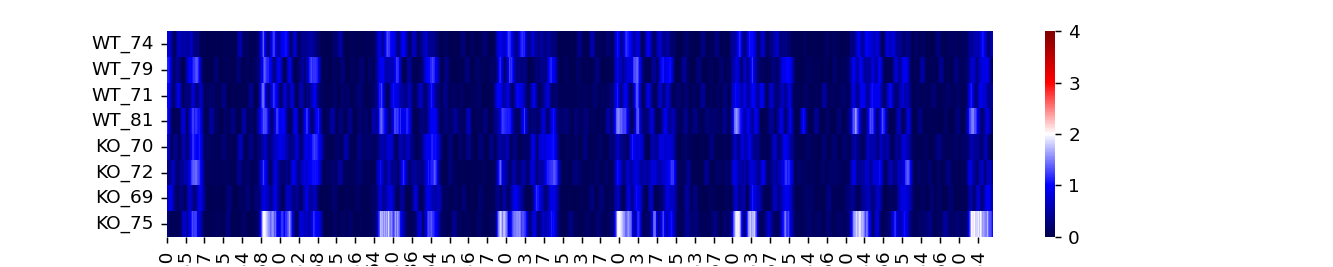

<AxesSubplot:>

In [85]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(10,2))

sns.heatmap(pd.concat([wt_motion, ko_motion],axis=1).rolling(60,center=True,min_periods=0).mean().T,cmap='seismic',vmin=0,vmax=4)

<IPython.core.display.Javascript object>


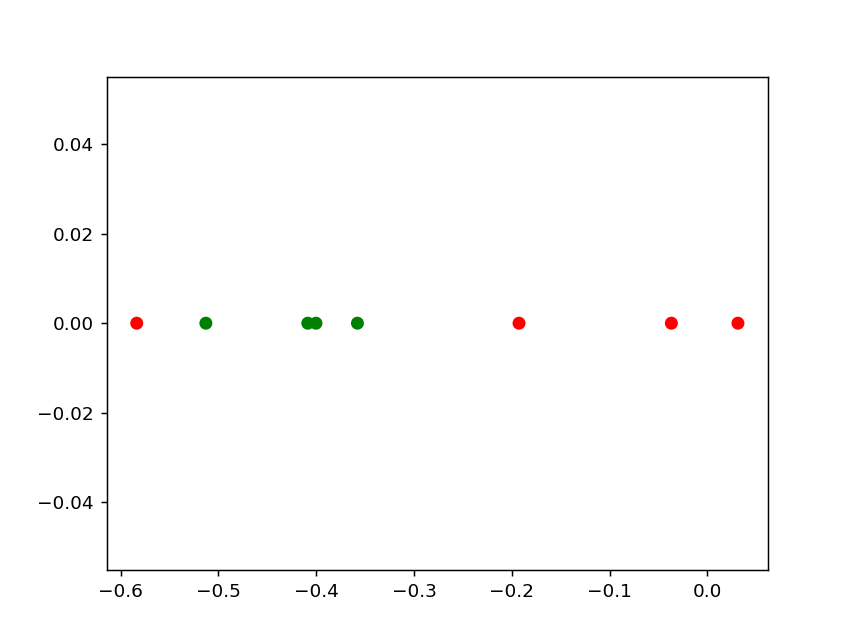

In [38]:
import math

def transform_radians(radians):
    shifted_radians = radians - math.pi
    wrapped_radians = shifted_radians % (2 * math.pi)
    transformed_radians = wrapped_radians - math.pi
    return transformed_radians

temperature_params['acrophase_rad_rng'] = temperature_params['acrophase_rad'].apply(transform_radians)
#transform_radians(np.pi)
fig,ax = plt.subplots()
ax.scatter(temperature_params['acrophase_rad_rng'].values,temperature_params['acrophase_rad_rng'].index,c=colors)


<IPython.core.display.Javascript object>


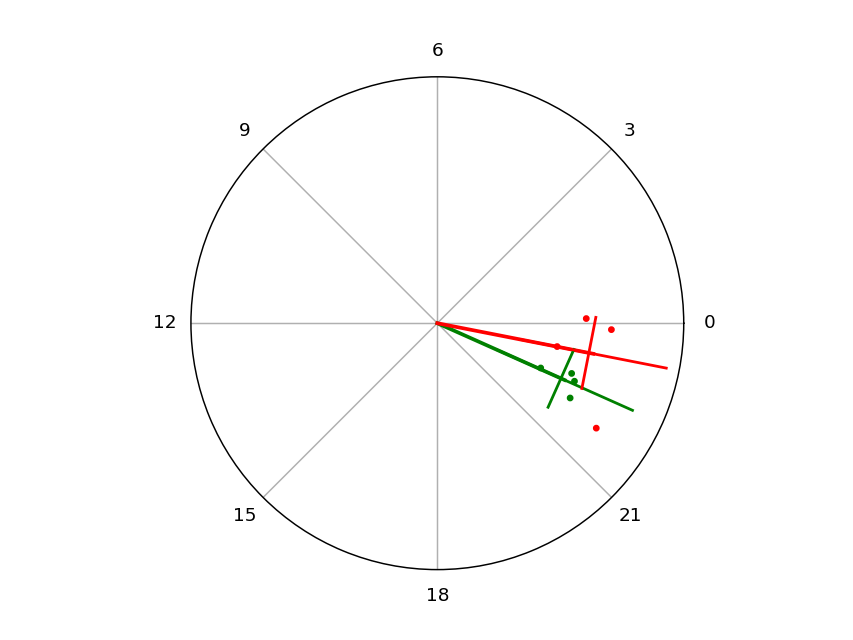

/tmp/ipykernel_51538/3586238983.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,3,6,9,12,15,18,21])


[]

In [45]:
import pycircstat as cs
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
colors = ['g' if c=='WT' else 'r' for c in temperature_params['geno']]
ax.scatter(temperature_params['acrophase_rad'] , temperature_params['amplitude'] ,
               c=colors, s=7, alpha=1)

wt_avg_theta = cs.mean(temperature_params['acrophase_rad'][temperature_params['geno']=='WT'])
wt_std_theta = cs.std(temperature_params['acrophase_rad'][temperature_params['geno']=='WT'])
wt_avg_amp = temperature_params['amplitude'][temperature_params['geno']=='WT'].mean()

ko_avg_theta = cs.mean(temperature_params['acrophase_rad'][temperature_params['geno']=='KO'])
ko_std_theta = cs.std(temperature_params['acrophase_rad'][temperature_params['geno']=='KO'])
ko_avg_amp = temperature_params['amplitude'][temperature_params['geno']=='KO'].mean()

ax.plot([wt_avg_theta, wt_avg_theta], [0, wt_avg_amp], 'g-', linewidth=2)
ax.plot([ko_avg_theta, ko_avg_theta], [0, ko_avg_amp], 'r-', linewidth=2)

ax.errorbar(wt_avg_theta, wt_avg_amp, xerr=ko_std_theta, yerr=.2, capsize=0, fmt="", c="g")
ax.errorbar(ko_avg_theta, ko_avg_amp, xerr=ko_std_theta, yerr=.2, capsize=0, fmt="", c="r")

ax.set_xticklabels([0,3,6,9,12,15,18,21])
ax.set_rticks([])
